## GRASS-GIS Remote Sensing

jupyter-notebook by Carlos H. Grohmann

In [1]:
# imports
import sys, os, itertools
import numpy as np
import pandas as pd
import subprocess
# from IPython.display import Image # can use this to display GRASS maps
# from osgeo import gdal
import matplotlib.pyplot as plt
# import seaborn as sns
# import plotnine as p9

%matplotlib inline

In [2]:
# requires version 7.8+
# create GRASS GIS runtime environment
gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"]).strip().decode() 
# gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"], text=True).strip() 

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass
import grass.script.setup as gsetup
import grass.script.array as garray
import grass.script.vector as gvect
import grass.jupyter as gj

# check GRASS version
print(gisbase)

/usr/local/grass/grass80


In [10]:
# set GRASS GIS session data
# rcfile = gsetup.init(gisbase, "/home/guano/HDD/grassdata/", "landsat5", "bsb")
rcfile = gsetup.init(gisbase, "/mnt/d/grassdata/", "landsat5", "bsb")

grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/mnt/d/grassdata/', 'LOCATION_NAME': 'landsat5', 'MAPSET': 'bsb'}


In [11]:
# overwrite for GRASS modules
ow = True

In [12]:
# set region - entire scene area
# n=8350000
# s=8130000
# w=65500
# e=300000
# res=30
# grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [13]:
# set region - subset for live
n=8292900
s=8232800
w=145200
e=221900
res=30
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [14]:
# check region
grass.parse_command('g.region', flags='pg')

{'projection': '1',
 'zone': '-23',
 'n': '8292900',
 's': '8232780',
 'w': '145200',
 'e': '221910',
 'nsres': '30',
 'ewres': '30',
 'rows': '2004',
 'cols': '2557',
 'cells': '5124228'}

In [15]:
# set data dir
# datadir = '/home/guano/HDD/geodata/landsat/BSB/'
# livedir = '/home/guano/HDD/Dropbox/USP/extensao/live_grass/grass_SR/'

datadir = '/mnt/d/geodata/landsat/BSB/'
livedir = '/mnt/d/Dropbox/USP/extensao/live_grass/grass_SR/'
    
l5c1_dir = 'LT05_L1TP_221071_20100907_20161013_01_T1'
l5c2_pre_dir = 'LT05_L2SP_221071_20100907_20200823_02_T1'

l5c1_basefilename = 'LT05_L1TP_221071_20100907_20161013_01_T1_B'
l5c2_pre_basefilename = 'LT05_L2SP_221071_20100907_20200823_02_T1_SR_B'

l5c1 = f'l5c1_prefire'
l5c2_pre = f'l5c2_prefire'


## Importar imagens Landsat Collection 1

In [13]:
# L5, col1, pre-fire
for band in [1,2,3,4,5,6,7]:
    tif = f'{datadir}{l5c1_dir}/{l5c1_basefilename}{band}.TIF'
    imp = f'{l5c1}_B.{band}'
    grass.run_command('r.import', input=tif, output=imp, extent='region', overwrite=True)

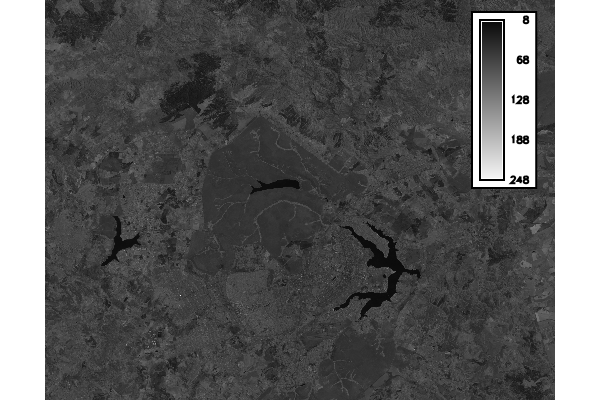

In [17]:
# display using grass.jupyter as png images

rast = f'{l5c1}_B.4'

# Create GrassRenderer instance
img = gj.GrassRenderer()

# Add a raster, vector and legend to the map
img.run('d.rast', map=rast)
# img.d_vect(map="streams")
img.run('d.legend',raster=rast, at=(55, 95, 80, 84), flags="b")

# Display map
img.show()

## Importar imagens Landsat Collection 2

In [23]:
# L5, col2, pre-fire
for band in [1,2,3,4,5,7]:
    tif = f'{datadir}{l5c2_pre_dir}/{l5c2_pre_basefilename}{band}.TIF'
    imp = f'l5c2_prefire_B.{band}'
    grass.run_command('r.import', input=tif, output=imp, extent='region', overwrite=True)

## Scale factor + offset - collection 2 

https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products?qt-news_science_products=0#qt-news_science_products

In [32]:
# scale factor and offset (VNIR, SWIR)
sfactor = 0.0000275
offset = -0.2

In [33]:
# L5, col2, pre-fire

# veja que aqui uso o nome inteiro do raster, sem usar variável

for band in [1,2,3,4,5,7]:
    r_in = f'l5c2_prefire_B.{band}'
    r_out = f'l5c2_prefire_SR_B.{band}'
    grass.mapcalc(f'{r_out} = ({r_in}*{sfactor}) + {offset}', overwrite=True)
    grass.run_command('r.null', map=r_out, setnull='1.01-500')  
    grass.run_command('r.colors', map=r_out, color='grey')

### cores - histogram stretch collection 2

https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products

In [25]:
# L5, col2, pre-fire

# lembrando que l5c2_pre = f'l5c2_prefire'

img = f'{l5c2_pre}_SR_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

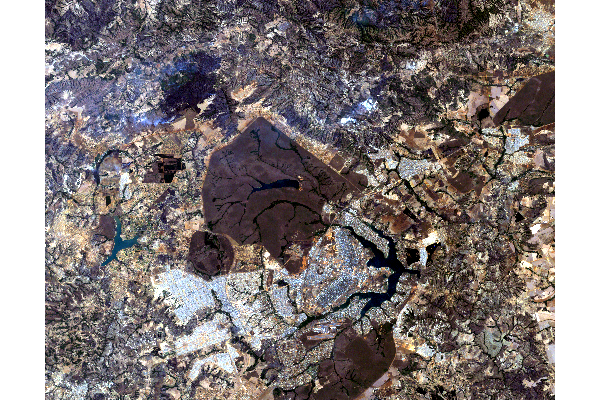

In [18]:
# display using grass.jupyter as png images

rast = f'{l5c2_pre}_SR_B.'

# Create GrassRenderer instance
img = gj.GrassRenderer()

# Add a raster, vector and legend to the map
# img.run('d.rast', map=rast)
img.run('d.rgb', red=f'{rast}3', green=f'{rast}2', blue=f'{rast}1')
# img.d_vect(map="streams")
# img.run('d.legend',raster=rast, at=(55, 95, 80, 84), flags="b")

# Display map
img.show()

## Rodar i.landsat.toar nas imagens Collection 1

In [24]:
# Reflectância de superfície, DOS

# a partir daqui começamos a usar a variável ao invés de escrever o nome todo do raster

dos = 'dos1'
r_in = f'{l5c1}_B.'
r_out = f'{l5c1}_SR_{dos}.'

met = f'{datadir}{l5c1_dir}/LT05_L1TP_221071_20100907_20161013_01_T1_MTL.txt'

grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, 
                  sensor='tm5', method=dos, overwrite=True)

In [16]:
# e se quisermos fazer TODOS os métodos DOS?

met = f'{datadir}{l5c1_dir}/LT05_L1TP_221071_20100907_20161013_01_T1_MTL.txt'

for dos in ['dos1','dos2','dos2b','dos3','dos4']:
    r_in = f'{l5c1}_B.'
    r_out = f'{l5c1}_SR_{dos}.'
    grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, 
                      sensor='tm5', method=dos, overwrite=True)

### cores - histogram stretch collection 1 DOS

In [28]:
# L5, col1, DOS
img = f'{l5c1}_SR_{dos}.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

## Rodar i.atcorr (6S) nas imagens Collection 1

https://grass.osgeo.org/grass78/manuals/i.atcorr.html  
https://grass.osgeo.org/grass78/manuals/i.landsat.toar.html

In [29]:
# Reflectância TOA

r_in = f'{l5c1}_B.'
r_out = f'{l5c1}_reflect_TOA_B.'

met = f'{datadir}{l5c1_dir}/LT05_L1TP_221071_20100907_20161013_01_T1_MTL.txt'

grass.run_command('i.landsat.toar', input=r_in, output=r_out, metfile=met, sensor='tm5', overwrite=True)

In [30]:
# Determinar horário de captura da imagem
# SCENE_CENTER_TIME = "13:04:57.5010560Z"
print(13 + 5/60)

# dos metadados do EarthExplorer
# Center Latitude dec -15.89080
# Center Longitude dec -47.95442

13.083333333333334


In [31]:
# arquivo de parâmetros

# 7                              # indicates that it is an TM image
# 09 07 13.083 -15.890 -47.954   # image capture hour/day/lat/long
# 1                              # the tropical atmospheric model
# 1                              # the continental aerosol model
# 50                             # the visibility for the aerosol model [km]
# -0.58                          # the terrain lies 580 meters above sea level [km] * -1
# -1000                          # image taken of a satellite sensor (1000)
# 25                             # spectral band, here TM5 B1



# 25	tm (landsat5) band 1 (0.430-0.560)
# 26	tm (landsat5) band 2 (0.500-0.650)
# 27	tm (landsat5) band 3 (0.580-0.740)
# 28	tm (landsat5) band 4 (0.730-0.950)
# 29	tm (landsat5) band 5 (1.5025-1.890)
# 30	tm (landsat5) band 7 (1.950-2.410)

In [32]:
# importar SRTM

srtmdir = '/home/guano/HDD/geodata/srtm/'

tiles = ['S16W048','S16W049','S17W048','S17W049']

for tile in tiles:
    hgt = f'{srtmdir}{tile}.hgt'
    grass.run_command('r.import', input=hgt, output=tile, overwrite=True)

# juntar tiles srtm em um só
grass.run_command('r.patch', input=tiles, output='srtm', overwrite=True)

In [55]:
# correção 6S - usar flag 'r' para input de reflectância

for band in [1,2,3,4,5,7]:
    r_in = f'{l5c1}_reflect_TOA_B.{band}'
    r_out = f'{l5c1}_SR_6S_B.{band}'
    dem = 'srtm'
    param_txt = f'{livedir}iatcorr_l5_b{band}.txt'
    grass.run_command('i.atcorr', input=r_in, elevation=dem, parameters=param_txt, 
        output=r_out, flags='r', range=(0,1), rescale=(0,1), overwrite=True)

### cores - histogram stretch collection 1 6S

In [34]:
# L5, col1, 6S
img = f'{l5c1}_SR_6S_B.'

(r,g,b) = (1,2,3)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

(r,g,b) = (4,5,7)
grass.run_command('i.colors.enhance', red=f'{img}{r}', green=f'{img}{g}', blue=f'{img}{b}')

## Vegetation indices

In [26]:
# qual índice de vegetação?
vi = 'ndvi'

In [36]:
# l5 c1, dos
l = [f'{l5c1}_SR_{dos}.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l5c1}_SR_{dos}_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  

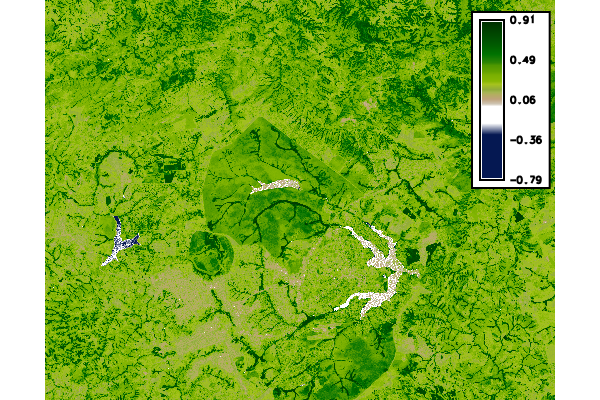

In [27]:
rast = f'{l5c1}_SR_{dos}_{vi}'

# Create GrassRenderer instance
img = gj.GrassRenderer()

# Add a raster, vector and legend to the map
img.run('d.rast', map=rast)
# img.d_vect(map="streams")
img.run('d.legend',raster=rast, at=(55, 95, 80, 84), flags="b")

# Display map
img.show()

In [37]:
# l5 c1, 6s
l = [f'{l5c1}_SR_6S_B.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l5c1}_SR_6S_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  

In [38]:
# l5 c2, prefire
l = [f'{l5c2_pre}_SR_B.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l5c2_pre}_SR_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  

In [39]:
# l5 c2, postfire
l = [f'{l5c2_post}_SR_B.{band}' for band in [1,2,3,4,5,7]]

out_vi = f'{l5c2_post}_SR_{vi}'

grass.run_command('i.vi', viname=vi, blue=l[0], green=l[1], red=l[2], nir=l[3], band5=l[4], band7=l[5],
              output=out_vi, overwrite = True)

# remove outliers
grass.run_command('r.null', map=out_vi, setnull='-1000--1.0,1.0-1000')  